In [19]:
import os
import pandas as pd


def extract_hota_table(log_file):
    table_data = []
    with open(log_file, 'r') as file:
        lines = file.readlines()
        table_start = False
        for line in lines:
            if line.startswith('HOTA:'):
                table_start = True
                continue
            if table_start and line.strip() != "":
                row_data = line.strip().split()
                table_data.append(row_data)
            if table_start and line.strip() == "":
                break
    headers = ['seq_name', 'HOTA', 'DetA', 'AssA', 'DetRe', 'DetPr',
               'AssRe', 'AssPr', 'LocA', 'OWTA', 'HOTA(0)', 'LocA(0)', 'HOTALocA(0)']
    df = pd.DataFrame(table_data, columns=headers)

    # df = pd.DataFrame(table_data[1:], columns=table_data[0])
    return df


def iterate_run_folders(base_folder):
    comparison_data = []
    run_folders = [folder for folder in os.listdir(
        base_folder) if os.path.isdir(os.path.join(base_folder, folder))]
    print("number of files found", len(run_folders))
    for run_folder in sorted(run_folders):
        run_path = os.path.join(base_folder, run_folder)
        eval_output_path = os.path.join(run_path, 'evaluation_output.txt')

        if os.path.isfile(eval_output_path):
            hota_df = extract_hota_table(eval_output_path)
            try:
                single_metric_for_the_run = hota_df[hota_df.seq_name == 'COMBINED']['HOTA'].astype(
                    float).values[0]
            except Exception as e:
                print(f"error with {eval_output_path}", e)
                single_metric_for_the_run = None

            comparison_data.append({
                'Run Name': run_folder,
                'HOTA Score': single_metric_for_the_run
            })

    comparison_df = pd.DataFrame(comparison_data)
    return comparison_df

In [20]:


base_folder = "MOT20"
comparison_df = iterate_run_folders(base_folder)

comparison_df['Resolution'] = comparison_df['Run Name'].str.extract(
    r'input_(\d+)')[0].astype(int)
comparison_df['Tracker'] = comparison_df['Run Name'].apply(
    lambda x: x.split('__')[0])
comparison_df['Confidence'] = comparison_df['Run Name'].apply(
    lambda x: float(x.split('__')[2].split('_')[1]))
comparison_df

number of files found 4


,Run Name,HOTA Score,Resolution,Tracker,Confidence
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25


In [21]:
comparison_df.groupby(['Resolution'])['Tracker'].count()

Resolution
1280    4
Name: Tracker, dtype: int64

In [22]:
comparison_df.sort_values(by=['Resolution', 'Confidence'], inplace=True)
comparison_df

,Run Name,HOTA Score,Resolution,Tracker,Confidence
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25


In [23]:

# Extracting resolution, tracker, and confidence
comparison_df['Resolution'] = comparison_df['Run Name'].str.extract(
    r'input_(\d+)')[0].astype(int)
comparison_df['Tracker'] = comparison_df['Run Name'].apply(
    lambda x: x.split('__')[0])
comparison_df['Confidence'] = comparison_df['Run Name'].apply(
    lambda x: float(x.split('__')[2].split('_')[1]))

FileNotFoundError: [Errno 2] No such file or directory: 'plots/effect_of_det_settings_on_HOTA_1280x1280.png'

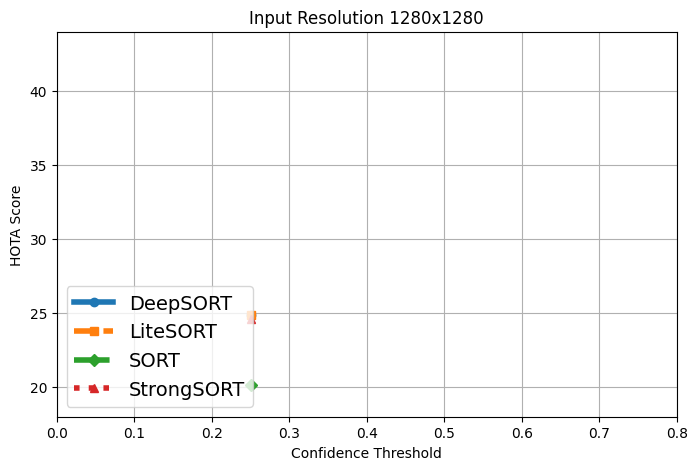

In [18]:
import matplotlib.pyplot as plt
import itertools
# Assuming 'comparison_df' is defined and has the necessary data

# List of distinct trackers
trackers = comparison_df['Tracker'].unique()
# More markers can be added if needed
markers = itertools.cycle(('o', 's', 'D', '^', 'v', '<', '>', 'P', '*'))
line_styles = itertools.cycle(('-', '--', '-.', ':'))

# Assigning a color to each tracker
color_map = {tracker: plt.cm.tab10(i) for i, tracker in enumerate(trackers)}

resolutions = sorted(comparison_df['Resolution'].unique())

# Set consistent style for all plots
plt.rcParams['lines.linewidth'] = 4  # Thicker lines
plt.rcParams['legend.fontsize'] = 14  # Larger legend font size

for res in resolutions:
    df = comparison_df[comparison_df['Resolution'] == res]

    # Smaller figure size
    plt.figure(figsize=(8, 5))  # Adjust the size to fit your page better

    for tracker in trackers:
        subset = df[df['Tracker'] == tracker]
        # Sort by confidence for plotting
        subset = subset.sort_values(by='Confidence')
        plt.plot(subset['Confidence'], subset['HOTA Score'],
                 marker=next(markers), linestyle=next(line_styles),
                 label=tracker, color=color_map[tracker])

    plt.xlabel('Confidence Threshold')
    plt.ylabel('HOTA Score')
    plt.title(
        f'Input Resolution {res}x{res}')

    # Set the x and y axis limits
    plt.xlim(0, 0.8)
    plt.ylim(18, 44)

    # Place the legend on the bottom left
    plt.legend(loc='lower left')

    plt.grid(True)

    # Save the plots to the specified directory with a DPI suitable for high-quality printing
    plt.savefig(
        f'plots/effect_of_det_settings_on_HOTA_{res}x{res}.png', dpi=300)
    plt.show()
    plt.close()  # Close the plot to avoid displaying it inline if using a notebook

# Plot FPS from Runtime log


In [24]:
comparison_df

,Run Name,HOTA Score,Resolution,Tracker,Confidence
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25


In [25]:
import re
# This pattern captures the resolution, confidence, and the FPS for MOT17-02-FRCNN
pattern = r'Running tracker: (.+) with Input Resolution: (\d+) and Confidence Threshold: ([.\d]+)\n.+MOT20-01\...\ntime: \d+s \| Avg FPS: ([.\d]+)'
log_text = open('fps_mot20.txt', 'r').read()
# Find all matches in the log text
matches = re.findall(pattern, log_text)

# Create a DataFrame from the matches
fps_data = pd.DataFrame(
    matches, columns=['Tracker', 'Resolution', 'Confidence', 'FPS'])

# Convert the types of the columns
fps_data['Resolution'] = fps_data['Resolution'].astype(int)
fps_data['Confidence'] = fps_data['Confidence'].astype(float)
fps_data['FPS'] = fps_data['FPS'].astype(float)
comparison_df = comparison_df.merge(
    fps_data, on=['Tracker', 'Resolution', 'Confidence'], how='left')

In [26]:
comparison_df.sort_values(by=['Resolution', 'Confidence'], inplace=True)
comparison_df

,Run Name,HOTA Score,Resolution,Tracker,Confidence,FPS
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25,6.0
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25,15.3
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25,18.0
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25,2.0


In [12]:
comparison_df.drop('Run')

,Run Name,HOTA Score,Resolution,Tracker,Confidence,FPS_x,FPS_y
0,DeepSORT__input_1280__conf_.25,24.897,1280,DeepSORT,0.25,NaN,6.0
1,LiteSORT__input_1280__conf_.25,24.896,1280,LiteSORT,0.25,NaN,15.3
2,SORT__input_1280__conf_.25,20.122,1280,SORT,0.25,NaN,18.0
3,StrongSORT__input_1280__conf_.25,24.573,1280,StrongSORT,0.25,NaN,2.0


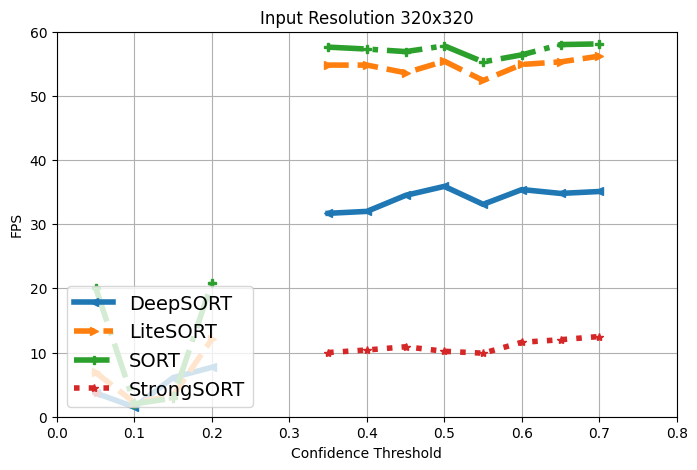

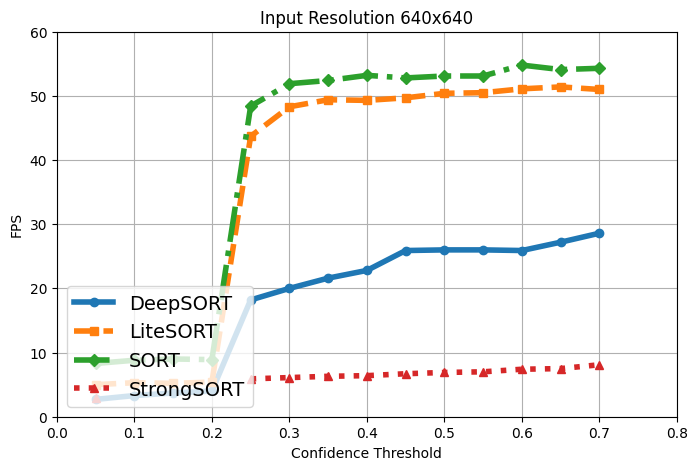

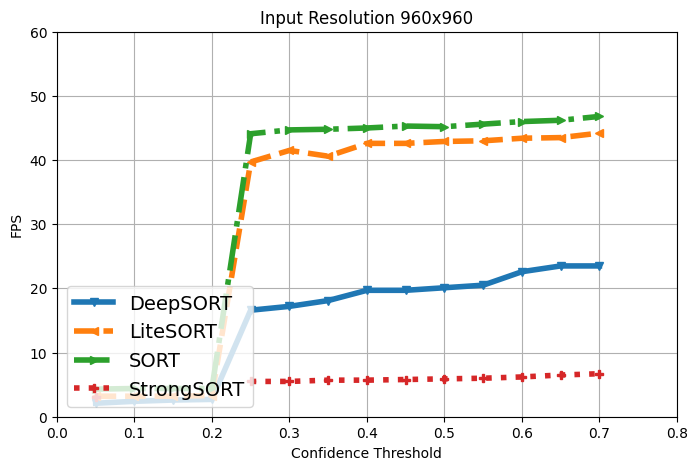

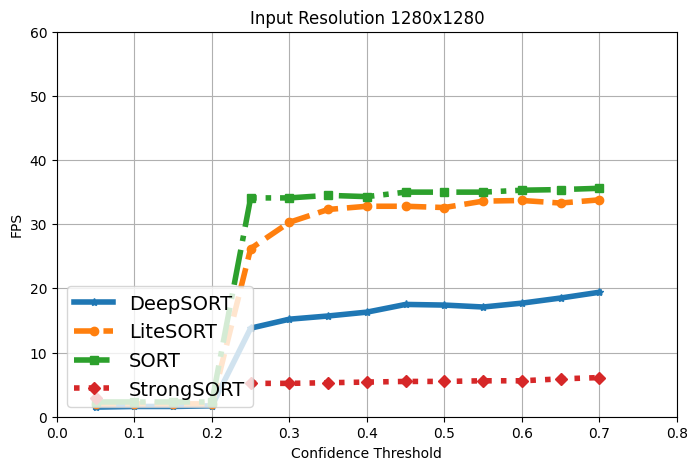

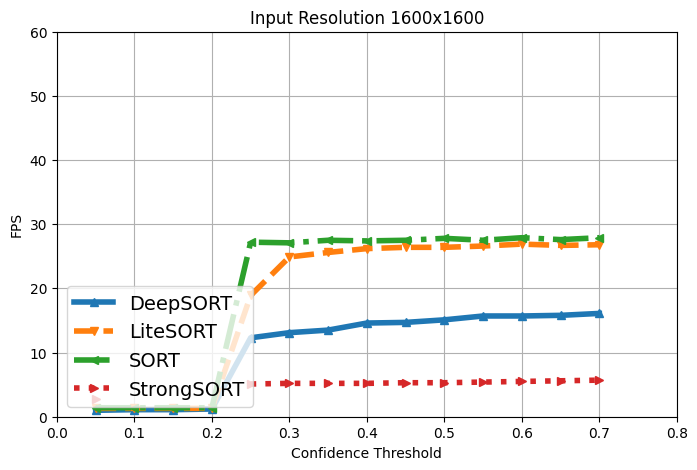

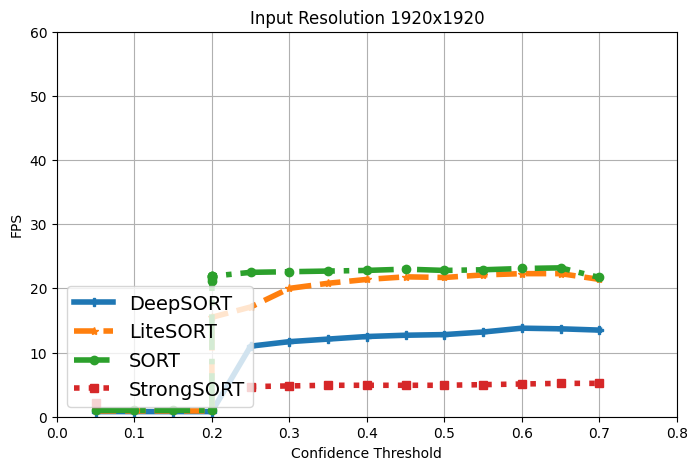

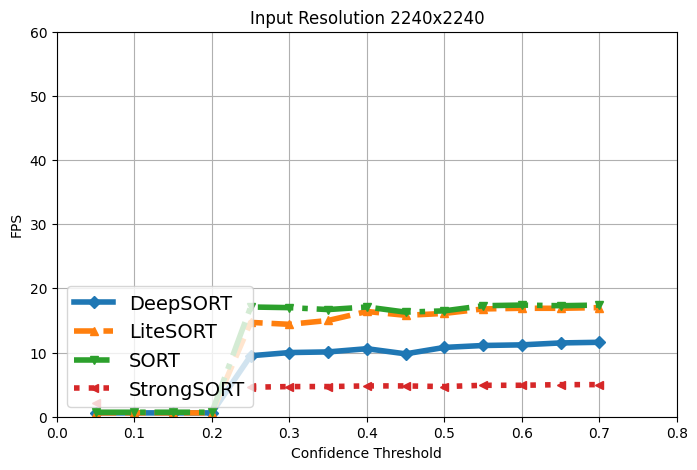

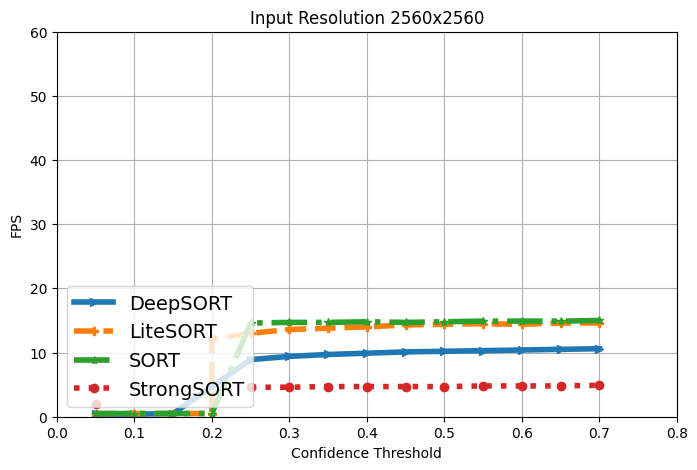

In [47]:
for res in resolutions:
    df = comparison_df[comparison_df['Resolution'] == res]

    # Smaller figure size
    plt.figure(figsize=(8, 5))  # Adjust the size to fit your page better

    for tracker in trackers:
        subset = df[df['Tracker'] == tracker]
        # Sort by confidence for plotting
        subset = subset.sort_values(by='Confidence')
        plt.plot(subset['Confidence'], subset['FPS'],  # Use 'FPS' instead of 'HOTA Score'
                 marker=next(markers), linestyle=next(line_styles),
                 label=tracker, color=color_map[tracker])

    plt.xlabel('Confidence Threshold')
    plt.ylabel('FPS')  # Update y-axis label to 'FPS'
    plt.title(f'Input Resolution {res}x{res}')

    # Set the x and y axis limits
    plt.xlim(0, 0.8)
    plt.ylim(0, 60)  # Adjust y-axis limits to the expected FPS range

    # Place the legend on the bottom left
    plt.legend(loc='lower left')

    plt.grid(True)

    # Update the file name to reflect that it's now about FPS
    plt.savefig(
        f'plots/effect_of_det_settings_on_FPS_{res}x{res}.png', dpi=300)
    plt.show()
    plt.close()